<a href="https://colab.research.google.com/github/hallmx/DL_medical_imaging_cle-ai/blob/master/histopath_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook is designed to be run as a Kaggle kernal*

# Histopathologic Cancer Cell Detection With Deep Leaning

Investigation of DNNs for detecting lymph node metastases in tissue sections of women with breast cancer.

### **Purpose**

Examination of lymph node tissue (obtained by biopsy or excision) for cancer cells is a common task for histopathologists. Here we aim to develop a DNN binary classifier that identifies metastatic tumour cells in histopthologic scans of lymph node sections. Such a classifier might find clinical use as an adjunct in timely cancer diagnosis 

### **Data**

The dataset is downloaded from Kaggle at https://www.kaggle.com/c/histopathologic-cancer-detection/data and consists of 220,000 images of size 96x96px. Only the centremost 32 x 32 pixels were examined to label the image as either positive or negative for metastatic cancer cells. Identification by a trained pathologist of only a single cancer cell in the central 32 x 32 pixel area would result in the image being labelled as positive.

The data is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset which has had duplicate images removed.

### **Methodology**

Over 187, 021 images were used to training a resnet50 pretrained convolutional neural network (CNN) using the Fastai2 deep learning library. Data augmentation was used with the full size images throughout training.

The outcome measure for the competition was the area under curve of the receiver operator characteristic (AUC-ROC). ROC are probability curves which plot true positives against true negatives as a measure of the models abiloity to distinguish between the two classes and is a common metric for assessing binary medical tests.

After training for 10 epochs with the model frozen, followed by 5 epochs unfrozen, an error rate of 0.04 was achieved.


### **Results**

Model evaluation on a held out test set of 33,004 samples reported a sensitivity 0.985, specificity 0.996 with AUC-ROC 0.991. ROC Curves and precsiion recall curves are presented in the notebook. 

Our results compare favourably with other SOTA models for histpathologic diagnosis and with a panel of human pathologists (see https://jamanetwork.com/journals/jama/fullarticle/2665774). This demonstrated that DNNs have promise as diagnostic tools in histopathologic cancer diagnosis and warrant further investigation in this field.

## Notebook setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
pip install fastai2

### Import libraries

In [0]:
# General
import os, pickle
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle
from sklearn import metrics
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2

# Visualizations
import matplotlib as plt
import matplotlib.patches as patches
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=14

# DL libraries
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from torch import torch

In [0]:
print("GPU: ", torch.cuda.is_available())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
python PIL version -  5.4.1


### Set parameters

In [0]:
data_path = Path("../input/histopathologic-cancer-detection")
print(os.listdir(data_path))

['train_labels.csv', 'train', 'test', 'sample_submission.csv']


In [0]:
BS = 64
SIZE = 96
NW = 4

## Data

### Get the data

In [0]:
# get the paths to imagefiles for train and test sets. 
data_path_train = data_path/"train"
data_path_test = data_path/"test" # Unlabelled Kaggle test set which we will not use further. 

In [0]:
df_train_data = pd.read_csv(data_path/'train_labels.csv')

In [0]:
df_train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [0]:
# Print row of images
def print_row_images(label, text):
  for i, idx in enumerate(df_train_data[df_train_data['label'] == label]['id'][:5]):
      path = os.path.join(data_path_train, idx)
      img = plt.imread(path + '.tif')
      ax[label,i].imshow(img)
      # Create a Rectangle patch
      box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
      ax[label,i].add_patch(box)
  ax[label,0].set_ylabel(text, size='large', color='gray')

In [0]:
labels = df_train_data['label'].value_counts()
label_neg = labels[0]
label_pos = labels[1]
             
data = {"number images": [label_neg, label_pos],
        "percent": [round((label_neg/(label_neg+label_pos)*100), 2), round((label_pos/(label_neg+label_pos)*100), 2)]}
pd.DataFrame(data, columns=["number images", "percent", ], index=["negative","positive"])

,number images,percent
negative,130908,59.5
positive,89117,40.5


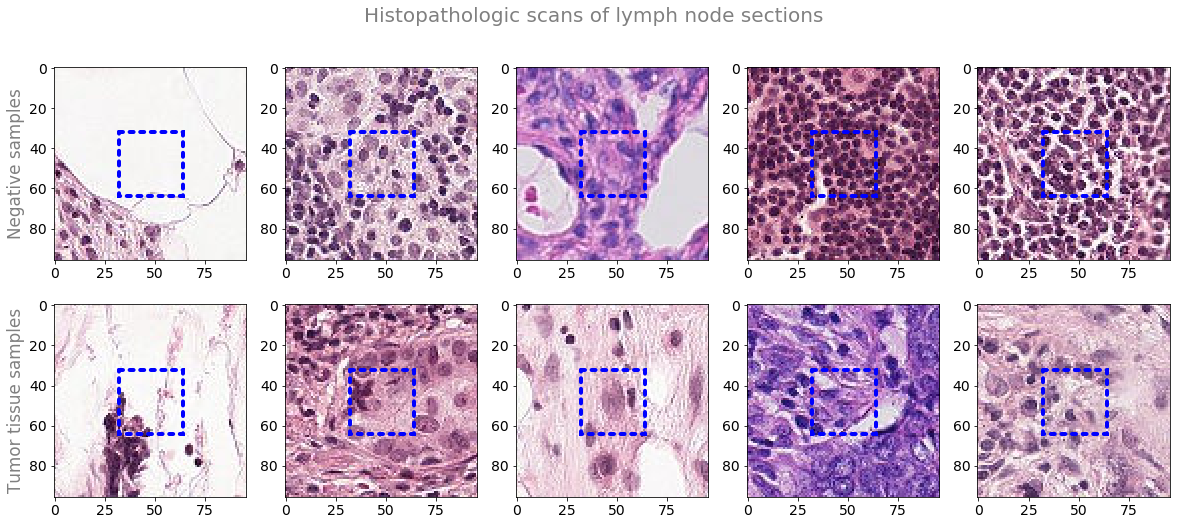

In [0]:
# plot a random sample of training images. 
# Note, only the center 32x32 pixels are used for labelling so we have highlighted these with a dashed box. 

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, color='gray')
print_row_images(0, 'Negative samples')
print_row_images(1, 'Tumor tissue samples')

### Set aside a test set

In [0]:
# Split out a labelled test set (df_test_labels)
test_set_fraction = 0.15

def split_train_test(df, frac=0.15):
    df_test = df.sample(frac=test_set_fraction, random_state=0)
    df_train = df.drop(df_test.index)
    return (df_train, df_test)

df_train, df_test = split_train_test(df_train_data, test_set_fraction)
print(f'Train set: {len(df_train)} samples, \nTest set: {len(df_test)} samples')

Train set: 187021 samples, 
Test set: 33004 samples


In [0]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

0    111301
1     75720
Name: label, dtype: int64
0    19607
1    13397
Name: label, dtype: int64


## Create a fastai dataloader

In [0]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


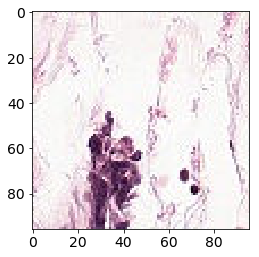

In [0]:
img_file = df_train.iloc[1]['id']
path = os.path.join(data_path_train, img_file)
img = plt.imread(path + '.tif')
plt.imshow(img)

In [0]:
items_train = [Path(str(data_path_train)+'/'+fn+'.tif') for fn in df_train['id'].values]

In [0]:
print(len(items_train))
items_train[:5]

187021


[Path('../input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif'),
 Path('../input/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'),
 Path('../input/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif'),
 Path('../input/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif'),
 Path('../input/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif')]

In [0]:
# function to split train_img between train/val (0.8/0.2) randomly
split_idx = RandomSplitter()(items_train)

In [0]:
class Labeller():
    '''path to label, eg. path -> ['0', '1']'''
    def __init__(self, df):
        self.df = df.set_index('id')
    def __call__(self, path):
        p = str(path).split('/')[-1][:-4]
        return self.df.loc[p]['label']
    

In [0]:
# tfms = tuple of images and labels
tfms = [[PILImage.create], [Labeller(df_train), Categorize]]

# specify item and batch level transforms (batch_tfms are executed on the GPU)
item_img_tfms = [ToTensor, FlipItem(0.5), RandomResizedCrop(SIZE, min_scale=0.35)]
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats), *aug_transforms(size=SIZE, max_rotate=30)]

In [0]:
# create the dataset from train_img paths, images and labels and split train/val 
dsets = Datasets(items_train, tfms, splits=split_idx)

In [0]:
def get_data(bs, sz):
    "return a dataloader with batch size `bs`, and image size `sz`"
    return dsets.dataloaders(bs=bs, num_workers=NW, after_item=item_img_tfms, after_batch=batch_tfms+[AffineCoordTfm(size=sz, align_corners=False)])

dls = get_data(BS, SIZE)

149617


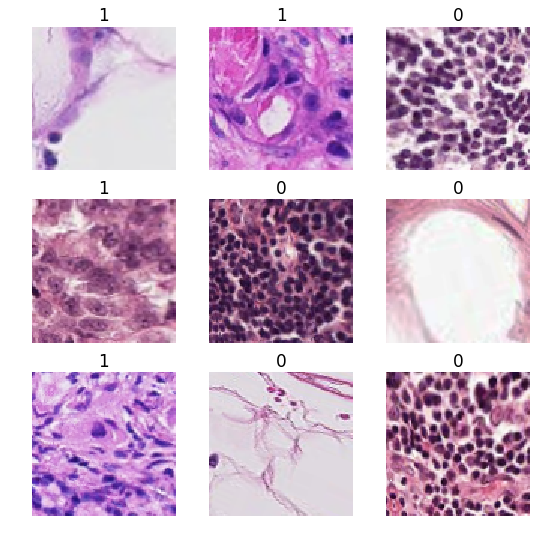

In [0]:
print(len(dls.train_ds.items))
dls.show_batch(max_n=9)

## Training loop

### Model

In [0]:
from torchvision.models import resnet50
model = resnet50

### Leaner and fit data.

In [0]:

def get_learner():
  "Function to create a fastai Learner object for training the 'model' on the data in the dataloader 'dls'"
  learn = cnn_learner(
    dls, 
    model, 
    opt_func=partial(Adam, wd=0.01, eps=1e-5), 
    cbs=[],
    metrics=error_rate, 
    config=cnn_config(ps=0.33))
  if torch.cuda.device_count() > 1: learn.to_parallel()
  return learn.to_fp16()

learn = get_learner()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


(0.005623413249850273, 3.548133827280253e-05)

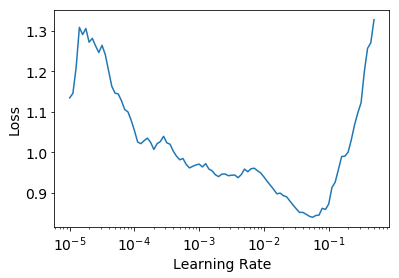

In [0]:
# learning rate finder to allow selection of an optimal learning rate
learn.lr_find(start_lr=1e-5, end_lr=1e-0)

In [0]:
# train 5 epochs with the pretrained layers frozen
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.281468,0.229860,0.091327,09:56
1,0.243763,0.191439,0.072024,08:47
2,0.230360,0.181653,0.071196,08:42
3,0.203664,0.168350,0.065234,08:39


epoch,train_loss,valid_loss,error_rate,time
0,0.199470,0.237713,0.085338,08:33
1,0.215446,0.181123,0.069404,08:38
2,0.207701,0.162570,0.060742,08:39
3,0.182392,0.149456,0.055662,08:33
4,0.170043,0.145972,0.055074,08:33


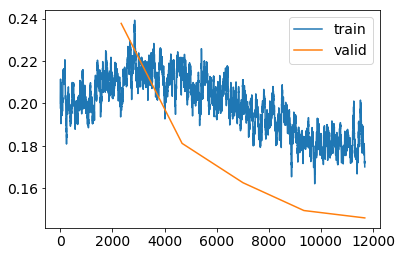

In [0]:
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_loss()

In [0]:
# unfreeze the pretrained layers and retrain at lower learning rate
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 2e-4, 2e-4))
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.202558,0.158235,0.061250,09:32
1,0.183222,0.151246,0.057962,10:39
2,0.168857,0.133176,0.049112,09:29
3,0.143468,0.120701,0.043311,09:31


## Test set predictions and evaluation

In [0]:
# make an item_list of the test set filepaths 
items_test = [Path(str(data_path_train)+'/'+fn+'.tif') for fn in df_test['id'].values]

In [0]:
# create a new dataloader from the test images and make predictions using the trained Learner..
dl = learn.dls.test_dl(items_test)
preds, _, targs = learn.get_preds(dl=dl, act = torch.sigmoid, with_decoded=True)

In [0]:
# the predictions
len(targs), targs[:5]

(33004, tensor([1, 1, 0, 1, 1]))

In [0]:
# get the test set labels
labeller_test = Labeller(df_test)
labels = [labeller_test(o) for o in items_test]
len(labels), labels[:5]

(33004, [1, 1, 0, 1, 1])

In [0]:
class BinClassMetrics():
  "Class to calculate and display common metrics for binary medical tests"
  def __init__(self, y, y_hat, preds, round_to=3):
    self.y = y
    self.y_hat = y_hat
    self.preds = preds[:,1]
    self.cm = metrics.confusion_matrix(y, y_hat)
    self.round_to = round_to
    self.labels = ['Cancer cells', 'Normal']

  def __call__(self):
    cols = ['Classifier', 'Precision', 'Recall (sensitivity)', 'F1 score', 'Sensitivity', 'Specificity', 'AUC_ROC'] 
    prf_df = self.prf_by_class
    data = ["Positive (cancer cells) vs negative (normal tissue)", prf_df.at[0, 'precision'], prf_df.at[0, 'recall'], prf_df.at[0, 'f1 score'], self.sensitivity, self.specificity, self.auc_roc]
    return pd.DataFrame(data, cols).T
    
  def __str__(self):
    m = metrics.classification_report(self.y, self.y_hat, digits=self.round_to)
    return m
    
  def _round(self, x): return round(x, self.round_to)

  @property
  def prf_by_class(self):
    m = metrics.precision_recall_fscore_support(self.y, self.y_hat)
    m = [[self._round(x) for x in y] for y in m]
    data = {'lesion': self.labels, 'precision': m[0], 'recall':  m[1], 'f1 score': m[2], 'support': m[3]}
    return pd.DataFrame(data)

  @property
  def sensitivity(self):
    cm = self.cm
    return self._round(cm[1,1]/(cm[1,1] + cm[1,0]))
    
  @property
  def specificity(self):
    cm = self.cm
    return self._round(cm[0,0]/(cm[0,0] + cm[0,1]))

  @property
  def auc_roc(self):
    return self._round(metrics.roc_auc_score(self.y, self.y_hat))

  @property
  def fpr_tpr(self):
    fpr, tpr, _ = metrics.roc_curve(self.y, self.preds)
    return fpr, tpr
    
  @property
  def confusion_matrix(self): 
    return self.cm

  def plot_roc(self, title='ROC curve'):
    fpr, tpr, _ = metrics.roc_curve(self.y, self.preds)
    roc = metrics.RocCurveDisplay(fpr, tpr, self.auc_roc, "")
    fig, ax = plt.subplots(figsize=(6,5))
    roc.plot(color='darkorange', lw=2, ax=ax)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.show

  def plot_pr(self, title='Precision recall curve'):
    from inspect import signature
    ap = metrics.average_precision_score(self.y, self.y_hat)
    p, r, _ = metrics.precision_recall_curve(self.y, self.preds)
    pr = metrics.PrecisionRecallDisplay(p, r, ap, "")
    fig, ax = plt.subplots(figsize=(6,5))
    pr.plot(color='darkorange', lw=2, ax=ax)
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(r, p, color='b', alpha=0.2, where='post')
    plt.fill_between(r, p, alpha=0.2, color='b', **step_kwargs)
    no_skill = collections.Counter(np.array(self.y_hat))[1] / len(self.y_hat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill line')
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.ylim([0.45, 1.02])
    plt.xlim([0.45, 1.02])
    plt.legend()
    plt.show
  
  def plot_cm(self, title='Confusion matrix'):
    cm_df = pd.DataFrame(columns=self.labels, index=self.labels, data=self.cm)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=1, cbar=False)
    plt.xlabel("Predicted label", fontsize=16, labelpad=5)
    plt.ylabel("True label", fontsize=16, labelpad=5)
    plt.title(f'{title.capitalize()}\n', fontsize=16, fontweight='bold')
    plt.show

In [0]:
m = BinClassMetrics(labels, targs, preds, round_to=3)
m()

,Classifier,Precision,Recall (sensitivity),F1 score,Sensitivity,Specificity,AUC_ROC
0,Positive (cancer cells) vs negative (normal tissue),0.956,0.972,0.964,0.934,0.972,0.953


In [0]:
print(m)

              precision    recall  f1-score   support

           0      0.956     0.972     0.964     19607
           1      0.957     0.934     0.945     13397

    accuracy                          0.956     33004
   macro avg      0.956     0.953     0.954     33004
weighted avg      0.956     0.956     0.956     33004



In [0]:
m.prf_by_class

,lesion,precision,recall,f1 score,support
0,Cancer cells,0.956,0.972,0.964,19607
1,Normal,0.957,0.934,0.945,13397


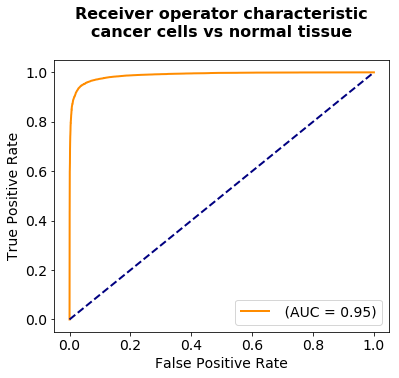

In [0]:
m.plot_roc(title="Receiver operator characteristic\nCancer cells vs normal tissue")

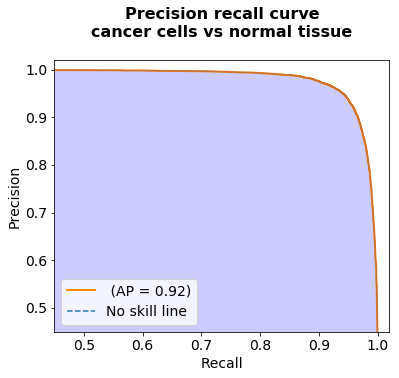

In [0]:
m.plot_pr(title='Precision recall curve\nCancer cells vs normal tissue')

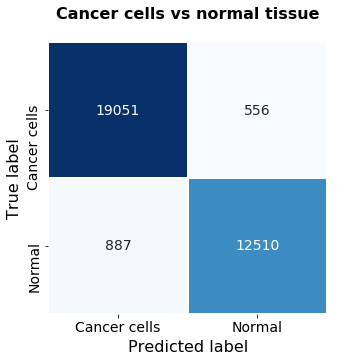

In [0]:
m.plot_cm(title='Cancer cells vs normal tissue')

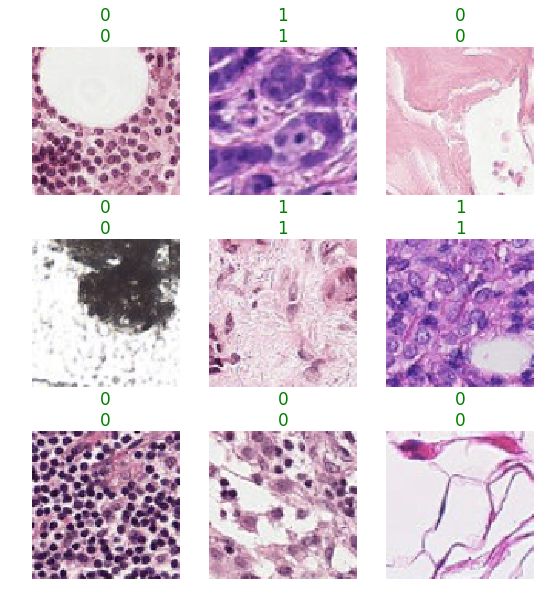

In [0]:
learn.show_results()

## References
Relevant references:
1. Original dataset is from pCam at https://github.com/basveeling/pcam
2. Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. https://jamanetwork.com/journals/jama/fullarticle/2665774
